# Bigram/Trigram model with MLP

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import requests
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [172]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


### Downloading data

In [2]:
url = "https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt"

# Local filename to save the downloaded file
filename = "names.txt"

# Download the file
response = requests.get(url)
if response.status_code == 200:
    with open(filename, "wb") as file:
        file.write(response.content)
    print(f"File downloaded successfully as {filename}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded successfully as names.txt


In [3]:
with open("names.txt", "r") as f:
    words = f.read().splitlines()

words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
char = sorted(list(set(''.join(words)))) # set(''.join(words)) concatena e remove todas as repetições de caracteres
stoi = {s:i+1 for i, s in enumerate(char)} #Para cada letra cria seu índice
stoi['.'] = 0  # '.' será o indice 0. Indicador de inicio e fim de uma palavra
itos = {i:s for s, i in stoi.items()} #Para cada indice deixa mapeado a sua letra

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# Building the dataset
block_size = 3
X, Y = [], []

for w in words[:5]:
  print(w)
  context = [0] * block_size

  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '------>', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ------> e
..e ------> m
.em ------> m
emm ------> a
mma ------> .
olivia
... ------> o
..o ------> l
.ol ------> i
oli ------> v
liv ------> i
ivi ------> a
via ------> .
ava
... ------> a
..a ------> v
.av ------> a
ava ------> .
isabella
... ------> i
..i ------> s
.is ------> a
isa ------> b
sab ------> e
abe ------> l
bel ------> l
ell ------> a
lla ------> .
sophia
... ------> s
..s ------> o
.so ------> p
sop ------> h
oph ------> i
phi ------> a
hia ------> .


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [11]:
X[0]

tensor([0, 0, 0])

Creating the embbeding for each letter. As we have 27 letters and we want each letter to have a two-dimensional embedding, our embedding tensor will have dimensions of 27 x 2 dimension.

In [63]:
C = torch.randn((27, 2))
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [64]:
emb[1]

tensor([[ 0.0863, -0.0732],
        [ 0.0863, -0.0732],
        [-0.4274, -1.4643]])

In [65]:
C[0]

tensor([ 0.0863, -0.0732])

In [66]:
C[:4]

tensor([[ 0.0863, -0.0732],
        [ 0.7072, -1.2049],
        [-0.5851, -0.8910],
        [-0.0388, -0.5382]])

In [67]:
X[:4]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13]])

### Reshaping a tensor

The tensor has dimensions of n x 3 x 2. The second dimension (3) is the letter dimension, and the third dimension is the embedding (2) of each letter. So instead of having the letters and their embeddings in two dimensions, we can concatenate the sequence of embeddings into an array of length 6.

In [68]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1).shape

torch.Size([32, 6])

### MLP

First layer has 100 neurons each receiving 6 inputs

In [69]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

First activation is Tanh

In [70]:
h = torch.tanh(emb.view(-1, 6) @ W1 +b1)

Second layer has 27 outputs, the numbers of letters

In [71]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [72]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [73]:
counts = logits.exp()

In [74]:
probs = counts / counts.sum(1, keepdim=True)

In [75]:
probs.shape

torch.Size([32, 27])

In [76]:
probs

tensor([[1.8562e-06, 1.4988e-11, 2.6510e-04, 8.6811e-07, 1.6746e-07, 5.9075e-08,
         2.9892e-09, 5.1617e-06, 1.4220e-03, 1.5923e-11, 7.8515e-04, 1.4544e-10,
         3.5891e-09, 6.2055e-01, 1.8069e-04, 2.2947e-05, 3.7560e-01, 1.0448e-09,
         1.7042e-07, 1.0375e-13, 5.9302e-08, 8.7509e-04, 2.8560e-04, 2.9708e-10,
         6.0697e-08, 2.8460e-07, 4.7396e-08],
        [7.1831e-10, 3.5662e-13, 1.3348e-06, 6.4817e-15, 1.5428e-12, 3.0777e-07,
         7.7392e-14, 1.7164e-11, 4.2991e-09, 8.0443e-16, 1.6818e-12, 2.7307e-12,
         1.4707e-14, 2.8758e-10, 4.1998e-09, 4.7947e-12, 1.0000e+00, 5.4786e-13,
         6.9831e-14, 1.1884e-19, 1.6385e-12, 6.0659e-13, 1.8729e-12, 3.5166e-14,
         1.8231e-10, 2.8995e-08, 5.5637e-08],
        [1.4960e-10, 1.6292e-12, 3.1970e-07, 7.7776e-13, 1.1925e-11, 5.6344e-11,
         9.0034e-05, 6.8429e-14, 1.2540e-06, 9.3218e-15, 4.8888e-08, 1.0838e-12,
         3.2943e-09, 3.8266e-10, 9.0853e-08, 9.7223e-10, 9.9991e-01, 4.6466e-11,
         5.8689e-

In [77]:
torch.arange(X.shape[0])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [82]:
probs[:,Y].shape

torch.Size([32, 32])

In [81]:
probs[torch.arange(X.shape[0]),Y]

tensor([5.9075e-08, 2.8758e-10, 3.8266e-10, 6.1212e-06, 1.5136e-09, 2.2947e-05,
        5.1157e-07, 1.3382e-14, 1.5798e-06, 5.1190e-15, 3.0550e-15, 6.7514e-14,
        1.4988e-11, 6.6739e-06, 7.9725e-10, 9.8335e-09, 1.5923e-11, 5.5735e-13,
        1.3865e-12, 1.5677e-01, 1.0766e-09, 1.0433e-09, 9.3174e-09, 4.5365e-07,
        1.3083e-08, 1.0375e-13, 4.7672e-06, 4.2660e-10, 2.2388e-11, 5.6861e-07,
        1.2203e-07, 4.0242e-05])

In [83]:
loss = -probs[torch.arange(X.shape[0]), Y].log().mean()

In [140]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [141]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 3), generator=g) ## Trigram
W1 = torch.randn((9, 200), generator=g) ## Three letters and three embedings, 9 inputs
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [142]:
print(f"Total parameters: {sum(i.nelement() for i in parameters)}")

Total parameters: 7508


All parameters with gradient descent

In [143]:
for p in parameters:
  p.requires_grad = True

In [158]:
lre = torch.linspace(0, -3, 5000)
lrs = 10**lre

In [159]:
lrs

tensor([1.0000, 0.9986, 0.9972,  ..., 0.0010, 0.0010, 0.0010])

In [160]:
epoch_list = []
loss_list = []
lr_list = []
lre_list = []

lossi = []
stepi = []

In [161]:
torch.randint(0, Xtr.shape[0], (64,))

tensor([181915, 126146,  64880,   1080, 176459,  79111,   6494, 151390,  77678,
         78736,  76682, 172531, 151093,  57125, 166259,  75829, 142772, 160421,
         34001,  21648, 134127,  63473, 141958,  33173, 176079, 160373,  19823,
         94991,  95603,  62856, 101353, 144804, 108415, 129917, 112928,   9605,
         27746, 154254,  22522, 142116, 122765, 105217, 131809,  31481, 129080,
        154770, 166202,  96240,  22868, 174458,  81031,  68222, 107416,  26093,
         41022,  34565, 123298, 152708,  26954,  51551,  12191, 157142,  50224,
        132340])

In [162]:
Xtr.shape[0]

182441

In [163]:
for epoch in range(5000):
  #MINIBATCH CONSTRUCT
  ix = torch.randint(0, Xtr.shape[0], (64,))
  ##FORWARD PASS
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 9) @ W1 + b1)
  logits = h @ W2 + b2
  #counts = logits.exp()
  #probs = counts / counts.sum(1, keepdim=True)
  #loss = -probs[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Ytr[ix])

  ### BACKWARD PASS
  for p in parameters:
    p.grad = None

  loss.backward()




  epoch_list.append(epoch)
  loss_list.append(loss.item())


  #lr = 0.1 if epoch < 1000 else 0.01
  lr = lrs[epoch]
  lr_list.append(lr)
  lre_list.append(lre[epoch])
  
  for p in parameters:
    p.data += -lr * p.grad

  stepi.append(epoch)
  lossi.append(loss.log10().item())

emb = C[Xtr]
h = torch.tanh(emb.view(-1, 9) @ W1 + b1)
logits = h @ W2 + b2
#counts = logits.exp()
#probs = counts / counts.sum(1, keepdim=True)
#loss = -probs[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Ytr)
print(f"Train Loss: {loss.item()}")

Train Loss: 2.336174488067627


In [164]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 9) @ W1 + b1)
logits = h @ W2 + b2
#counts = logits.exp()
#probs = counts / counts.sum(1, keepdim=True)
#loss = -probs[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Ydev)
print(f"Dev Loss: {loss.item()}")

Dev Loss: 2.344120502471924


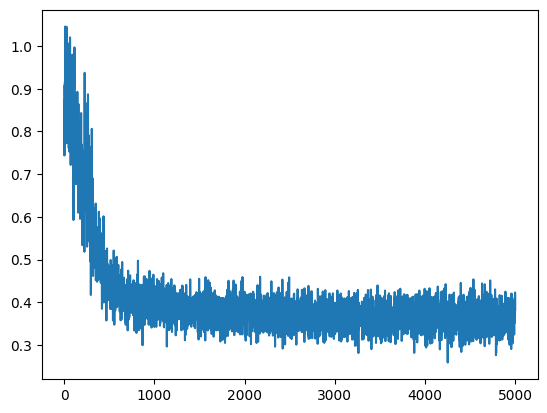

In [165]:

plt.plot(stepi, lossi)

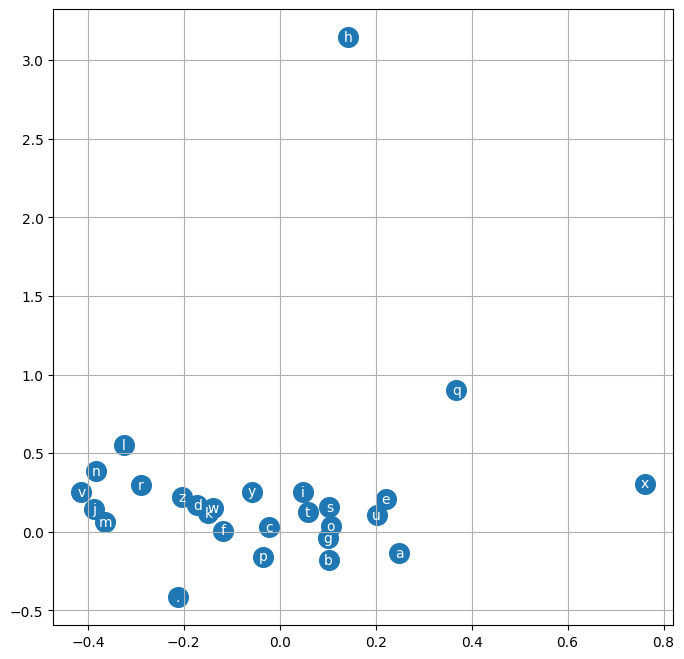

In [166]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

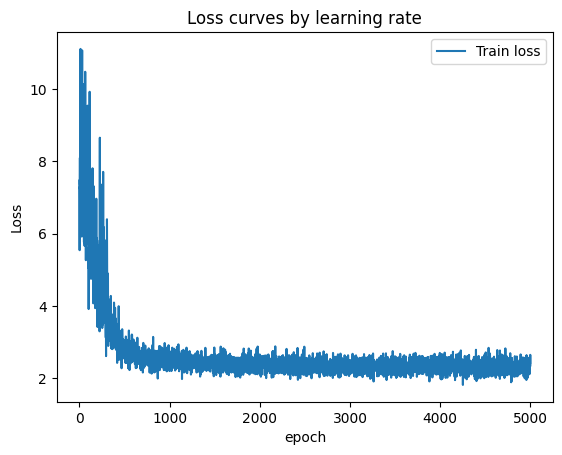

In [170]:
plt.plot(epoch_list, loss_list, label="Train loss")
plt.title("Loss curves by learning rate")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend()


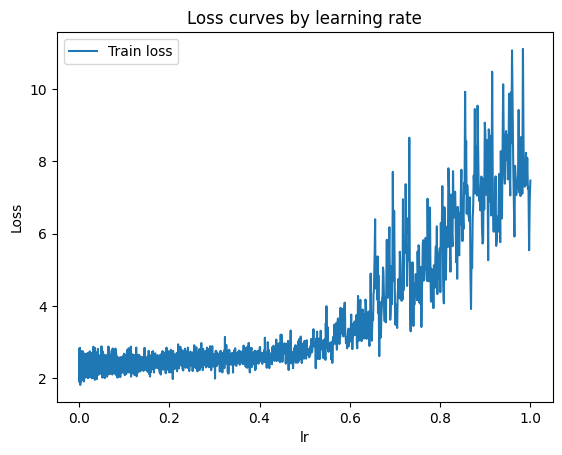

In [168]:
plt.plot(lr_list, loss_list, label="Train loss")
plt.title("Loss curves by learning rate")
plt.ylabel("Loss")
plt.xlabel("lr")
plt.legend()



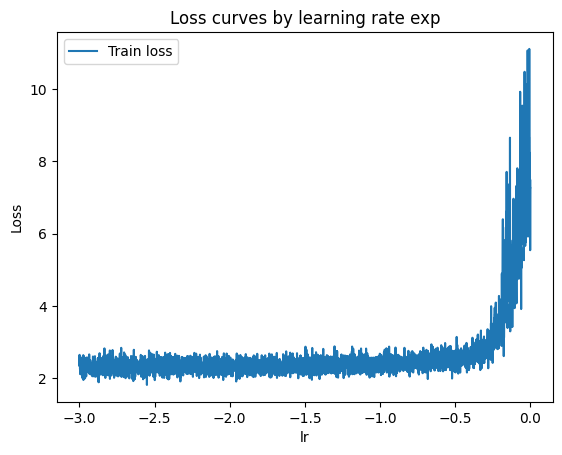

In [169]:
plt.plot(lre_list, loss_list, label="Train loss")
plt.title("Loss curves by learning rate exp")
plt.ylabel("Loss")
plt.xlabel("lr")
plt.legend()

In [171]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

careah.
ami.
hlvi.
kimrex.
thay.
salassa.
jaronen.
deliyna.
kaqui.
nelenia.
ceriiv.
kaleig.
dham.
joce.
quinn.
sroilea.
jadbi.
wazero.
dearynix.
kaeliigsan.
